<div align="center">
<head>

# Análisis de señales sonoras para la clasificación de las vocales características del castellano rioplatense

## Trabajo final de Análisis de Señales, dictado en 2021 por Jorge Runco
### Carla Soprano, Marzo de 2023.
<head>
</div>

$\hspace{1cm}$ En este trabajo desarrollaremos la teoría de algunos algoritmos, programas y modelos de análisis de señales que culminarán en un clasificador de vocales a partir de audios. Todos los archivos necesarios para los códigos de cada sección se encuentran en la carpeta adjunta. Se trabajará exclusivamente en python.


In [109]:
# Correr esta celda para ignorar mensajes de python y para descargar los datos y audios del análisis (en Colab)

import warnings
warnings.filterwarnings('ignore')

#!pip install gdown
#!gdown --folder https://drive.google.com/drive/folders/1h90B1M_P17eYCmFbGRkJfeVvv5KibIfA?usp=sharing -O /Archivos_señales


# Sección 1: Transformada de Fourier Discreta (DFT)


  $\hspace{1cm}$ Comenzaremos hablando un poco sobre la teoría detrás del análisis de frecuencias que podemos realizar sobre una señal sonora.
  
  $\hspace{1cm}$ Dada una señal tomada en el tiempo de a intervalos iguales $t_s$ entre $0$ y $T$, teniéndose en total un conjunto discreto de $N$ datos, su transformada de Fourier discreta, o DFT por sus siglas en inglés, se calcula como **[1]**:

  $$\begin{equation}
  X[k] = \sum_{n=0}^{N-1}x[n]\cdot e^{-i~2\pi~k~n~/~N}
  \tag{1}
  \end{equation}$$

  $\hspace{1cm}$ Con esta operación, pasamos al dominio de frecuencias de la señal original; esto quiere decir que pudimos descomponerla como suma de senos y cosenos de un espectro discreto de frecuencias $f = k/(Nt_s)$ que van desde $k=0$ hasta $k=N-1$ (si se evalúa para todos los enteros, resulta la extensión periódica de la DFT). El intervalo que abarca el espectro, entonces, es desde $f=0$ hasta $f=1/t_s\equiv f_s=N/T$.

  $\hspace{1cm}$ Tengamos en cuenta que, para tener información de las frecuencias que caracterizan a una señal, debemos al menos tener $2$ puntos por periodo, lo que es equivalente a pedir que la frecuencia máxima que podemos identificar sea igual a la mitad de la frecuencia de muestreo $f_s$. Esta condición se conoce como el teorema de muestreo o de Shannon-Nyquist. En la DFT esto queda evidente ya que $X[k]=X^*[N-k]$, es decir, el espectro (que se puede demostrar que es real para señales reales) queda espejado en torno a $k=N/2$ o $f=f_s/2$, con lo cual para frecuencias mayores que eso no tenemos nueva información.

$\hspace{1cm}$ Veremos un poco más adelante un gráfico de ejemplo con el espectro de una señal, pero antes vamos a escribir un código que calcule **(1)** para una señal arbitraria.



In [110]:
import numpy as np

# Nos guiamos del código propuesto en [2].

def DFT_directo(x):

    """ Calcula la DFT del array 1D x. """

    x = np.asarray(x, dtype=float)      # Si x es una lista, lo convertimos a array de numpy
    N = x.shape[0]                      # Tomamos la cantidad de elementos de x

    n = np.arange(N)                    # Vector de Nx1 con enteros desde 0 hasta N-1
    k = n.reshape((N, 1))               # Vector de 1xN con enteros desde 0 hasta N-1

    M = np.exp(-2j * np.pi * k * n / N) # Efectúa esta operación para todo n (filas) para todo k (columnas)
    # M nos devuelve una matriz de NxN

    return np.dot(M, x)                 # Multiplicamos la matriz M con el vector x

$\hspace{1cm}$ Esta función nos devuelve un vector $X(k)$ de $N$x$1$, cuyos elementos se obtuvieron como $X_i(k)=\sum_{j=0}^{N-1}M_{ij}x_j$. Notemos que el cálculo implica $N$ sumas para los $N$ valores de frecuencias, con lo cual tendríamos que computar $N^2$ operaciones para hallar la DFT de una señal $x$ de $N$ elementos. Para señales con muchos datos, el costo computacional escala muy rápido.


# Sección 2: Transformada Rápida de Fourier (FFT)

$\hspace{1cm}$ En 1965, Cooley y Turkey publicaron un paper en 1965 **[3]** donde propusieron un método para reducir la cantidad de operaciones, y así reducir el tiempo de cómputo de la DFT. A este método se le llama la transformada rápida de Fourier (FFT por sus siglas en inglés).

$\hspace{1cm}$ Para entender cómo funciona, veamos primero una versión simplificada, asumiendo que tenemos un número par de muestras ($N=2M$, $M\in\mathbb{Z}$).

$\hspace{1cm}$ Notemos que la DFT de una señal, como la que vimos en **(1)**, se puede reescribir separando los términos con índice par de aquellos con índice impar:

$$\begin{align}
X[k] &= \sum_{n=0}^{N-1} x[n] \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x[2m] \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x[2m + 1] \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x[2m] \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x[2m + 1] \cdot e^{-i~2\pi~k~m~/~(N/2)}
\end{align}$$

$\hspace{1cm}$ Ambos términos pueden considerarse en sí mismos como DFT del subconjunto de datos con índice par e impar respectivamente, que podemos redefinir como $X_p[k]$ y $X_i[k]$:

$$X[k] = X_p[k]+e^{-i~2\pi~k~/~N}X_i[k]$$

$\hspace{1cm}$ Ahora el tamaño de estas transformadas es $N/2$, ya que ambos subconjuntos encierran la mitad de los datos totales. Vamos a ver que para $N> k\geq N/2$ podemos aprovecharnos de cierta simetría en esta expresión. Dado un $k$ cualquiera, vale:

$$X_p[k+N/2]=\sum_{m=0}^{N/2-1}x[2m]\cdot e^{-i~2\pi~(k+N/2)~m~/~(N/2)}=\sum_{m=0}^{N/2-1}x[2m]\cdot e^{-i~2\pi~k~m~/~(N/2)}e^{-i~2\pi~m}$$

$\hspace{1cm}$ Como $e^{-i~2\pi~m}=1 ~~\forall m$, tenemos

$$X_p[k+N/2]=X_p[k]$$

$\hspace{1cm}$ Y de la misma manera ocurre para los datos con índice impar, pero con signo opuesto ya que $e^{-i~2\pi~(k+N/2)~/~N}$$=e^{-i~2\pi~k~/~N}e^{-i~2\pi~/2}$$=-e^{-i~2\pi~k~/~N}$. Resulta entonces:

$$X[k]=X_p[k]+e^{-2\pi ik/N}X_i[k]\tag{2}$$

para $0\leq k<N/2$, y

$$X[k'=k+N/2]=X_p[k]-e^{-2\pi ik/N}X_i[k]\tag{3}$$

para $N/2\leq k'<N$ (es decir, usamos nuevamente los valores de $X_p$ y $X_i$ evaluados en los $k<N/2$). A esta recombinación de los términos se le conoce como "butterfly operation" (operación mariposa), debido a la forma en que se la representa en el flujo de señales.

<div align="center">
    <img src="./Archivos_señales/Butterfly-FFT.png">

**Figura 1: Diagrama del flujo de señales conectando la entrada $x$ con la salida $y$ que depende de éste, para una operación mariposa de una FFT de orden 2 $[4]$.**
</div>


$\hspace{1cm}$ De esta manera, notemos que nos quedan para sumar los $N/2$ términos de la trasformada par y los $N/2$ de la transformada impar, evaluados solamente en $N/2$ valores de $k$. Luego, se suman para los $N/2$ primeros valores de $k$, y se restan para los $N/2$ valores que quedan. Así, en total pasamos a tener $2(N/2)^2+N\sim N\cdot N/2$ operaciones, lo que para $N$ grandes implica reducir el tiempo de cómputo casi a la mitad.

$\hspace{1cm}$ Naturalmente, para las transformadas $X_p$ y $X_i$ que quedaron podríamos aplicar un procedimiento similar, mientras $N/2$ también sea par. En ese caso, nos quedaría dividida la DFT original en 4 "sub" DFTs de $N/4$ elementos cada una, con lo cual para armar la $X_p$ necesitaremos $N/2$ sumas, así como para la $X_i$, y evaluaremos cada sub DFT en $N/4$ valores de $k$ (en este paso se tienen que realizar entonces $4~(N/4)^2+2N/2=N\cdot N/4+N$ operaciones; es todo análogo a lo que vimos arriba). Finalmente, sumaremos la $X_p$ y la $X_i$ según vimos en **(2)** y **(3)** para rearmar la DFT total, agregando al total $N$ sumas más. Tenemos entonces $N\cdot N/4+2N$ operaciones en este caso.

$\hspace{1cm}$ De hecho, si $N$ fuera divisible $j$ veces por 2, podríamos repetir este procedimiento $j$ veces, reduciendo el orden de operaciones a $N(j+N\cdot2^{-j})$. Esto es porque cada iteración $i$ nos dividirá la DFT en $2^i$ DFTs de $N/2^i$ elementos, con lo cual tenemos $2^i(N/2^i)^2$ operaciones, y luego para ir reorganizando en cada paso tendremos $N$ sumas más dadas por la segmentación de los $k$ (que debemos reorganizar con las _butterfly_). Cuando $N$ sea una potencia de $2$, o sea $N=2^k$, la cantidad de operaciones será la más óptima posible, $N\cdot k+N\sim N\ln N$.



In [111]:

# Nuevamente nos inspiramos del código propuesto en [2].

def FFT(x, N_max, j, n_operaciones):

    """

    Se implementa recursivamente la FFT de Cooley-Tukey para ``x`` lista o array 1D.

    ``N_max`` es el tamaño original de x, que debe guardarse ya que la implementación
    recursiva actualiza a cada paso el valor de N para cada subgrupo de datos.

    N_max debe ser divisible por 2 al menos ``j`` veces.

    ``n_operaciones`` es una lista en la que iremos guardando la cantidad
    de sumas que se efectúan en cada paso del algoritmo.

    """

    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    # Si N no es divisible por 2 al menos j veces, devuelve error
    if N % 2 > 0 and N != 1:
        raise ValueError("No es posible dividir {} por 2.".format(N))

    # Cuando se llega a subgrupos de tamaño N_max/2^j (tras j pasos), se pasa a efectuar la DFT normal
    elif N <= (N_max / 2**j):
        n_operaciones.append(N*N) # Aquí se computan N sumas para N frecuencias
        return DFT_directo(x)

    else:
        """
        X_par y X_impar se arman tomando elementos de x cada 2 índices y aplicando la FFT nuevamente.

        Cuando se llega a orden j, se calcula la DFT como se ve en la condición anterior,
        y entonces se van concatenando los k hasta llegar a N_max y se van aplicando
        para X_par y X_impar las operaciones butterfly.
        """
        X_par = FFT(x[::2], N_max, j, n_operaciones)
        X_impar = FFT(x[1::2], N_max, j, n_operaciones)
        factor = np.exp(-2j * np.pi * np.arange(N) / N) # El factor que multiplica los impares

        n_operaciones.append(N) # En la última línea se computan N sumas (las butterfly)
        return np.concatenate([X_par + factor[:int(N / 2)] * X_impar, X_par + factor[int(N / 2):] * X_impar])
        # Así devolvimos el vector X(k) resultante, de Nx1


$\hspace{1cm}$ Ahora apliquemos la función anterior a un ejemplo concreto para contar la cantidad de operaciones que requiere la FFT tal como se definió más arriba:


In [112]:

N = 1024
orden = 10

"""
N es la cantidad de elementos que tendrá la señal x.
El orden será la cantidad de veces que apliquemos la recursión propuesta
por Cooley y Tukey, por lo que N deberá ser divisible por 2 al menos la
cantidad de veces establecida por este número.
"""

 # Aquí iremos guardando cuántas sumas requiere cada paso:
n_operaciones = []

print("\nTenemos N={} datos que dividir por 2 unas j={} veces.\n".format(N, orden))

# Generamos una lista con N reales tomados al azar entre 0 y 1:
x = np.random.random(N)

# Invocamos la función:
FFT(x, N, orden, n_operaciones)

print("En la FFT se efectuaron {} operaciones,".format(sum(n_operaciones)),end=" ")
print('lo que es igual a N(j+N/2^j) = {}\n'.format(N*(orden+N/2**orden)))
print("Comprobamos que este algoritmo es unas {:.2f} veces".format(N**2/sum(n_operaciones)),end=" ")
print("más rápido que la DFT directa,")
print("la cual requiere de N^2={} operaciones.".format(N**2))


Tenemos N=1024 datos que dividir por 2 unas j=10 veces.

En la FFT se efectuaron 11264 operaciones, lo que es igual a N(j+N/2^j) = 11264.0

Comprobamos que este algoritmo es unas 93.09 veces más rápido que la DFT directa,
la cual requiere de N^2=1048576 operaciones.



$\hspace{1cm}$ Este procedimiento lo podemos generalizar para cualquier señal con $N=N_1N_2$ datos **[3]**, siendo $N_1,N_2\in\mathbb{Z}$. Se separa la DFT original en $N_1$ subgrupos de $N_2$ datos, siendo cada subgrupo del tipo $\{x_{n},x_{N_1+n},...,x_{(N_2-1)N_1+n}\}; n=0,...,N_1-1$. Nos quedarán entonces $N_1$ DFTs (que distinguimos con el subíndice $n$) con $N_2$ términos cada una, de la forma:

$$\begin{align}
X_n[k]&=\sum_{m=0}^{N_2-1}x[N_1m+n]\cdot e^{-i~2\pi~k~(N_1m+n)~/~N}\\
&=e^{-i~2\pi~nk~/~N}\sum_{m=0}^{N_2-1}x[N_1m+n]\cdot e^{-i~2\pi~k~m~/~N_2} \\
\end{align} \tag{4}
$$

donde usamos que $N_1/N=1/N_2$.

$\hspace{1cm}$ Mostremos que también podemos reducir la cantidad de evaluaciones en $k$ aprovechando las raíces de la unidad.

$$ \begin{align}
X_n[k+N_2]&=\sum_{m=0}^{N_2-1}x[N_1m+n]\cdot e^{-i~2\pi~(k+N_2)~(N_1m+n)~/~N}\\
&=X_n[k]\cdot e^{-i~2\pi~N_2~(N_1m+n)~/~N} = X_n[k]\cdot e^{-i~2\pi~(Nm+N_2n)~/~N}\\
&=X_n[k]\cdot e^{-i~2\pi~m}e^{-i~2\pi~n~/~N_1}= X_n[k]\cdot e^{-i~2\pi~n~/~N_1}
\end{align}$$

donde usamos nuevamente que $e^{-i~2\pi~m}=1~~\forall m$.

$\hspace{1cm}$ Y en general para $k+jN_2$, con $j$ un entero entre $0$ y $N_1-1$:

$$X_n[k+jN_2]=X_n[k]\cdot e^{-i~2\pi~jn~/~N_1}$$

$\hspace{1cm}$ Por ende, para calcular las DFTs de **(4)** basta con calcular las $N_2$ sumas de los $N_1$ subgrupos de $x[n]$ evaluadas en $N_2$ valores de $k$.

$\hspace{1cm}$ Nos queda entonces la transformada total:

$$X[k+jN_2]=\sum_{n=0}^{N_1-1}X_n[k]\cdot e^{-i~2\pi~jn~/~N_1} \tag{5}$$

con $0\leq k<N_2$, y donde vamos evaluando el resto de los $k$ variando $j\in\{0,1,...,N_1-1\}$, que implicará simplemente cambiar el producto con las raíces de la unidad (se les llama "twiddle factor" o "factor de giro"). Es decir, quedan $N_1$ sumas con $N_1$ productos con las raíces de la unidad, $N_2$ veces. En el caso visto anteriormente, teníamos $N_1=2$ y $N_2=N/2$, y las raíces de la unidad eran simplemente $+1$ y $-1$ (por eso no los consideramos como _twiddle factor_; de haber sido otros se duplicaría la cantidad de operaciones del úlimo paso al agregar un producto en cada _butterfly_).

$\hspace{1cm}$ La expresión en **(5)** la podemos pensar como $N_2$ nuevas DFT con $N_1$ datos, que vendrían a ser el conjunto de las $N_1$ DFTs que evaluamos para cada subgrupo en $N_2$ valores de $k$. Así es como redujimos las $N^2$ operaciones de la DFT original, a tener sólo $N_1N_2^2+N_1^2N_2=N(N_2+N_1)$. Si $N$ pudiera descomponerse como productos de primos, $N=p_1^{a_1}p_2^{a_2}...p_r^{a_r}$, iterando sobre el procedimiento explicado recién, como mínimo podremos reducir la cantidad de operaciones de la DFT a $N\cdot\sum_ia_ip_i$.

$\hspace{1cm}$ En el caso de que $N$ justo sea un número primo, se pueden agregar un 0 al final de los datos para tener un $N$ múltiplo de 2.


$\hspace{1cm}$ Para redondear esta sección, comparemos efectivamente el tiempo que tarda python en computar la DFT de una señal con la función DFT_directo(x), con la nueva función FFT(x) y con la función de numpy np.fft.fft(x).

In [113]:
# Calculamos el tiempo que tarda cada algoritmo en correr

%timeit DFT_directo(x)
%timeit FFT(x, N, orden, n_operaciones)
%timeit np.fft.fft(x)

79.3 ms ± 8.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.1 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11 µs ± 257 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


$\hspace{1cm}$ Vemos que, si bien la función FFT(x) que armamos arriba mejora el tiempo de cómputo con respecto a DFT_directo(x), está lejos de mejorarlo 100 veces como esperábamos a partir de la cantidad de operaciones que redujimos. Esto se debe a la recursividad de las funciones, la incorporación de la lista n_operaciones y los condicionales que agregamos, los cuales ralentizan el código (de hecho en **[2]** se sugiere una versión del código más rápida). Como queda claro por el tiempo de cómputo de la DFT usando la función de numpy, se pueden agregar muchas más optimizaciones al código para que opere más rápido, por lo que a partir de ahora seguiremos con este paquete **[5]**.


# Sección 3: armónicos

$\hspace{1cm}$ Podemos entonces valernos de la FFT aplicada sobre una señal sonora de unos segundos para ver qué frecuencias están sonando. Tenemos que tener en cuenta algo muy importante, que es la frecuencia de muestreo, $f_s=1/t_s$, que ya hemos mencionado en la teoría más arriba. Si buscamos analizar frecuencias más altas que $f_s/2$, nuestro espectro no va a ser capaz de detectarlas. Para evitar preocuparnos por esto, los micrófonos suelen muestrear a una $f_s$ de aproximadamente $44,1$ kHz, que es el doble de la máxima frecuencia típicamente audible en humanos, estimada en $20$ kHz.

$\hspace{1cm}$ En el código que sigue vamos a ejemplificar cómo analizar un registro sonoro de entre los que están en la carpeta **/Archivos_señales/Audios** que adjuntamos: se trata de la nota musical C4 (do correspondiente a la 4ta octava del piano); hay 4 ejemplos en distintos instrumentos para analizar.


In [114]:
import matplotlib.pyplot as plt # Para graficar
import numpy as np # Para realizar operaciones matemáticas
import wave # Para leer y crear archivos .wav
import struct # Para traducir de hexadecimal a decimal y viceversa
import scipy.signal as sps # Para buscar máximos locales

# Primero vamos a importar los datos del archivo y guardarlos

class DatosArchivo:
    def __init__(self, archivo):
        # Abrimos el archivo que queremos analizar
        wavefile = wave.open(archivo, 'r')

        n = []
        amplitud = []

        # n_datos es lo que llamamos N, la cantidad de datos en nuestra señal
        n_datos = wavefile.getnframes()
        print("Cantidad de datos en el archivo:", n_datos)

        n_canales = wavefile.getnchannels()
        print("Canales: ", n_canales) # 2 es estéreo, 1 es mono

        # Toma la frecuencia de muestreo de la metadata del archivo
        fsamp = wavefile.getframerate()
        print("Cantidad de datos por segundo (f de muestreo): ", fsamp)
        print("Segundos de audio: ", n_datos/fsamp)

        for i in range(0, n_datos):
            # Va leyendo los datos uno por uno para guardarlos en las listas n y amplitud
            wavedata = wavefile.readframes(1)
            data = struct.unpack("<{n}h".format(n=n_canales), wavedata)

            n.append(i)
            amplitud.append(int(data[0])) # Nos quedamos sólo con el primer canal

        if n_datos%2==1: # Para la FFT queremos trabajar con un número par de datos
            n = n[:-1]
            amplitud = amplitud[:-1]
            n_datos = n_datos-1

        self.n = n
        self.amplitud = amplitud
        self.n_datos = n_datos
        self.fsamp = fsamp

Cantidad de datos en el archivo: 29750
Canales:  1
Cantidad de datos por segundo (f de muestreo):  11025
Segundos de audio:  2.6984126984126986


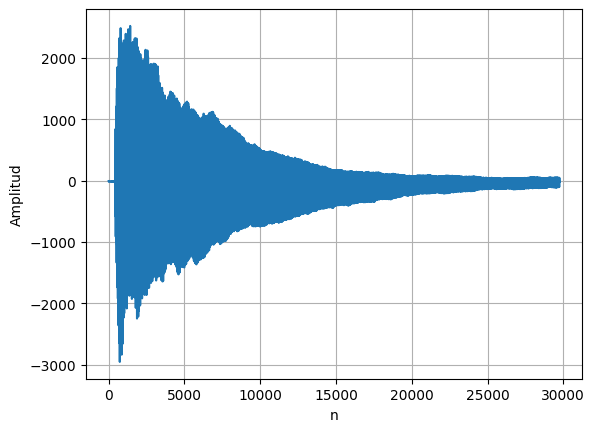

In [115]:
# Elegimos alguno de los archivos sonoros en formato .wav y guardamos los datos
# Los archivos se encuentran en la carpeta adjunta y fueron descargados de [6].
archivo = "./Archivos_señales/Audios/piano-C4.wav"
datos = DatosArchivo(archivo)

# Graficamos la señal
plt.plot(datos.n, datos.amplitud)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


$\hspace{1cm}$ Ahora le aplicaremos la función FFT de numpy para hallar su espectro.

In [116]:
def fft_archivo(n, amplitud, n_datos, fsamp):

    # Aplicamos Fast Fourier Transform para obtener el espectro de frecuencias
    data_fft = np.fft.fft(amplitud)      # Quedan complejos
    data_fft = np.abs(data_fft)          # Sacamos su valor absoluto
    data_fft = np.fft.fftshift(data_fft) # Desplazamos [0,fsamp] a [-fsamp/2,fsamp/2], para centrar el espectro en f=0

    # Calcula las frecuencias tomando múltiplos de fsamp/n_datos (hasta k=n_datos)
    f = np.fft.fftshift(np.fft.fftfreq(n_datos, d=1/fsamp))

    return f, data_fft


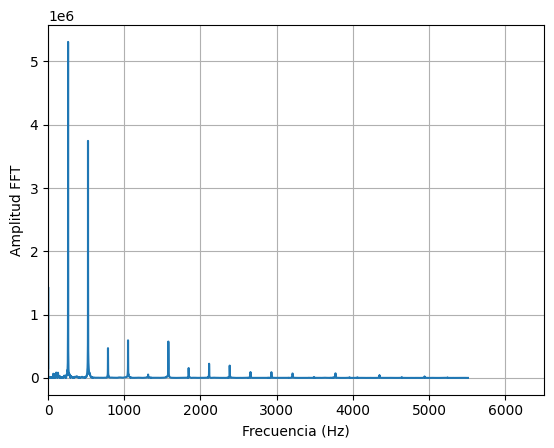

In [117]:
f, data_fft = fft_archivo(datos.n, datos.amplitud, datos.n_datos, datos.fsamp)

# Graficamos el espectro
plt.plot(f, data_fft)
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud FFT")
plt.xlim(0,datos.fsamp/2+1000) # Recortamos el gráfico para ver sólo las f >= 0
plt.grid()

$\hspace{1cm}$ Notemos que en el espectro, a pesar de lo que mencionamos más arriba, la máxima frecuencia que podemos analizar es de aproximadamente $5,5$ kHz; los audios tomados han sido remuestreados a una $f_s$ menor que $44$ kHz para que no pesen tanto. Sin embargo, la frecuencia de muestreo resultante de $f_s=11025$ Hz es suficiente para el análisis que estamos haciendo aquí.

$\hspace{1cm}$ Vemos también que por encima del ruido predominan ciertas frecuencias, con una amplitud mucho mayor que el resto. El primero de estos picos debería corresponder a la frecuencia de la nota que denominamos C4, de alrededor de $261$ Hz **[7]**, y se denomina la fundamental. El resto son los armónicos que se generan por resonancias propias de cada instrumento, y tendrán valores de frecuencia múltiplos de la fundamental.

$\hspace{1cm}$ En el código, los identificaremos con la función de SciPy, find_peaks **[8]**.





In [118]:
def hallar_armonicos(f, data_fft, fmin, fmax, d):
    # Buscamos los armónicos en el espectro de la señal

    rango_f = np.where((f > fmin) & (f < fmax))
    base = np.mean(data_fft[np.min(rango_f):np.max(rango_f)])

    # La función find_peaks de scipy.signal busca los máximos locales de los datos
    # (devuelve el índice donde se encuentran)
    picos,_ = sps.find_peaks(data_fft[np.min(rango_f):np.max(rango_f)], base + 20, distance = d)
    picos = picos + len(data_fft[:np.min(rango_f)])

    return picos

Fundamental y armónicos esperados para C4: 
261.63 Hz, 523.25 Hz, 784.88 Hz, 1046.50 Hz, 1308.13 Hz, 1569.76 Hz, 1831.38 Hz, 2101.01 Hz.
Fundamental y armónicos de C4 hallados: 
261.64 Hz, 523.27 Hz, 785.65 Hz, 1048.76 Hz, 1312.25 Hz, 1577.96 Hz, 1844.79 Hz, 2113.09 Hz.


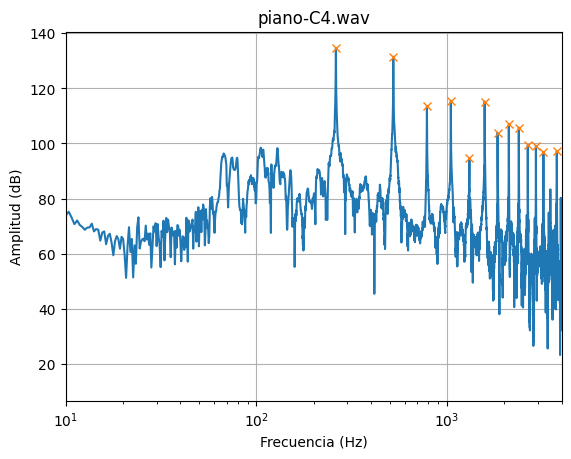

In [119]:
# Vemos los valores que esperamos obtener de los picos:
# la frecuencia fundamental correspondiente al C4 y múltiplos de la misma
print("Fundamental y armónicos esperados para C4: ")
for i in range(1,8):
    print("{:.2f} Hz".format(i*261.626), end=", " )
print("{:.2f} Hz.".format(8*262.626))

# Graficamos en escala logarítmica, que es más representativa de la audición humana
log_data_fft = 20*np.log10(data_fft)
picos_espectro = hallar_armonicos(f, log_data_fft, 200, 4000, d = 400)
plt.plot(f, log_data_fft)

print("Fundamental y armónicos de C4 hallados: ")
for p in picos_espectro[:7]:
    print("{:.2f} Hz".format(f[p]), end=", " )
print("{:.2f} Hz.".format(f[picos_espectro[7]]))

# Graficamos los armónicos identificados
plt.plot([f[p] for p in picos_espectro], [log_data_fft[p] for p in picos_espectro], "x")
plt.xlim(10,4000)
plt.xscale("log")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.title(archivo.split("/")[-1])
plt.grid()
plt.show()


$\hspace{1cm}$ Para distintos instrumentos, todos los armónicos van a seguir esa relación, por lo que las frecuencias de una misma nota serán iguales, pero podemos distinguirlos entre sí a partir de las amplitudes relativas de los armónicos (entre otras cosas en las que no nos meteremos ahora).

<img src="./Archivos_señales/piano-spectrum.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
<img src="./Archivos_señales/trumpet-spectrum.png"
     alt="Markdown Monster icon"
     style="float: right; margin-right: 10px;" />
<img src="./Archivos_señales/violin-spectrum.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
<img src="./Archivos_señales/flute-spectrum.png"
     alt="Markdown Monster icon"
     style="float: right; margin-right: 10px;" />

# Sección 4: Formantes

$\hspace{1cm}$ Se puede hacer un análisis similar al que acabamos de hacer sobre las frecuencias que resuenan en distintos instrumentos musicales para la voz humana.

$\hspace{1cm}$ En el caso del habla, cuando se pronuncia una vocal se emiten muchas frecuencias, de entre las que pueden reconocerse la fundamental y sus armónicos que resuenan gracias a la forma en que vibran nuestras cuerdas (o pliegues) vocales. Veamos un ejemplo usando el mismo código de antes para obtener el espectro de un registro sonoro donde se tiene a una persona pronunciando una vocal aislada.



Cantidad de datos en el archivo: 6204
Canales:  1
Cantidad de datos por segundo (f de muestreo):  48000
Segundos de audio:  0.12925
Fundamental y armónicos hallados: 
92.84 Hz, 193.42 Hz, 286.27 Hz, 386.85 Hz, 479.69 Hz, 572.53 Hz, 

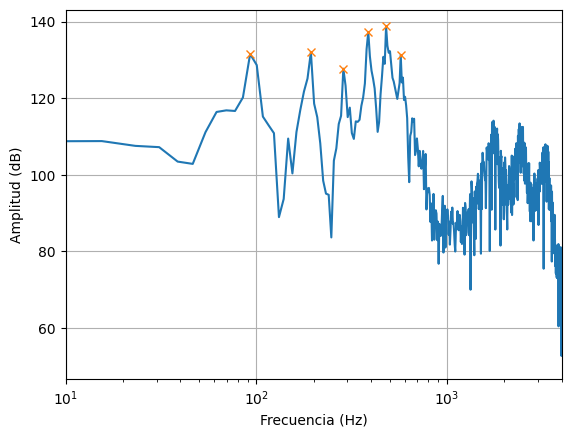

In [120]:
archivo_vocal = "./Archivos_señales/Audios/vocal_e.wav"
datos_vocal = DatosArchivo(archivo_vocal)

f, data_fft = fft_archivo(datos_vocal.n, datos_vocal.amplitud, datos_vocal.n_datos, datos_vocal.fsamp)

# Graficamos en escala logarítmica, que es más representativa de la audición humana
log_data_fft = 20*np.log10(data_fft)
picos_espectro = hallar_armonicos(f, log_data_fft, fmin = 50, fmax = 4000, d = 10)

print("Fundamental y armónicos hallados: ")
try:
    for p in picos_espectro[:7]:
        print("{:.2f} Hz".format(f[p]), end=", " )
    print("{:.2f} Hz.".format(f[picos_espectro[7]]))
except:
    pass

plt.plot(f, log_data_fft)
plt.plot([f[p] for p in picos_espectro], [log_data_fft[p] for p in picos_espectro], "x")
plt.xlim(10,4000)
plt.xscale("log")
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.grid()
plt.show()


$\hspace{1cm}$ Vemos que, como en el caso de los instrumentos musicales, algunos armónicos se amplifican más que otros, dándonos a entender que la anatomía propia del aparato fonador modifica las resonancias en distintos rangos de frecuencias. Esto, es esperable, hará que para cada persona el espectro se vea distinto, pero vamos a estudiar en particular cómo cambia el espectro para distintas vocales, y qué es lo que las caracteriza para que podamos identificarlas.

$\hspace{1cm}$ Un modelo popular para explicar cómo se genera sonido durante el habla es el modelo de fuente-filtro **[9]**. La frecuencia fundamental se genera en las cuerdas vocales, y el tracto vocal actúa como un resonador que dará forma al espectro según la persona y el sonido a generar. Podemos pensar a estas cavidades resonantes como filtros que dejan pasar mejor algunas frecuencias que otras (que serán, por supuesto, aquellas que resuenan).

$\hspace{1cm}$ A estas frecuencias se las denomina _formantes_. Se identifican como los picos de la envolvente del espectro de la señal sonora, y físicamente se tratan de los modos de vibración del tracto vocal.

$\hspace{1cm}$ Si bien uno puede (y lo hace constantemente) cambiar la frecuencia fundamental con la que se pronuncia una vocal, las formantes van a mantenerse, y es gracias a esto que podemos identificarlas sin importar quién esté hablando.

$\hspace{1cm}$ El modelo propone que la señal original, la fuente del sonido generada por las vibraciones de los pliegues vocales, pasa por un filtro dado por el tracto vocal, que amplifica algunas frecuencias según el fonema deseado. La imagen que sigue ilustra este proceso **[10]**.

<div align="center">
    <img src="./Archivos_señales/source_filter_model3.png">

**Figura 2: Modelo fuente-filtro del tracto vocal, a partir del cual se ilustra la producción del espectro de distintas vocales.**
</div>



$\hspace{1cm}$ En la primera gráfica, vemos la producción de una frecuencia fundamental y todos sus armónicos, los cuales resuenan cada vez con menor amplitud. Independientemente de las frecuencias que suenen, la pendiente será de aproximadamente -12 dB por octava **[11]**.

$\hspace{1cm}$ Los diferentes órganos del tracto vocal serán los que den forma a la segunda gráfica, que ejemplifica un filtro de formantes. Se suele llamar a cada pico con una F y un número que las ordena de más grave a más aguda: la primera formante es F1, la segunda F2, etc.

$\hspace{1cm}$ Se suele explicar de manera simplificada **[12]** las aparición de las resonancias que caracterizan las dos primeras formantes a partir de la separación del tracto vocal en dos cavidades principales: la primera se encuentra entre la parte superior de la laringe hasta la lengua (lo que llamaríamos coloquialmente la garganta), y la segunda desde la lengua hasta los labios (la cavidad dentro de nuestra boca). Muchos músculos que conforman el tracto vocal influyen en los modos resonantes, como la lengua, el cuello, la mandíbula, el paladar blando, los labios y la faringe. Su tamaño determinará las frecuencias características de cada persona, pero tenemos cierta libertad de expandirlos o contraerlos para generar los sonidos que conforman el habla.

<div align="center">
    <img src="./Archivos_señales/container-labels-vocal-tract_orig.jpg">

**Figura 3: Cavidades principales en las que resuenan las formantes 1 y 2 $[12]$.**
</div>


$\hspace{1cm}$ Por ejemplo, si la mandíbula baja (como en la vocal "a"), la cavidad correspondiente a la primera formante se hace más chica y la segunda se hace más grande, con lo cual F1 se hará más aguda y F2 más grave. Al adelantar los labios, ambas cavidades se vuelven más largas y las formantes se harán más graves (como sucede con la vocal "u"), y al abrirse (como en una sonrisa) las cavidades se vuelven más cortas y las formantes más agudas (como la "i").

$\hspace{1cm}$ En general, las primeras dos formantes bastan para caracterizar una vocal **[11]**. El resto de formantes caracterizan el sonido particular de cada persona.

$\hspace{1cm}$ Para distinguir cada vocal a partir de su espectro, entonces, tenemos que encontrar la manera de poder identificar sistemáticamente las formantes y clasificarlas.

$\hspace{1cm}$ Una vez hecho esto, deberíamos poder armar un gráfico como este:

<div align="center">
    <img src="./Archivos_señales/Spanish_Vowel_Formants_Bradlow1995.png">

**Figura 4: Formantes en castellano $[13]$.**
</div>



$\hspace{1cm}$ Este tipo de gráfico, donde se ubican las primeras dos formantes en promedio dentro de algún grupo, va a ser distinto para cada idioma e incluso para distintos dialectos. Por ejemplo, las formantes del japonés son parecidas a la del castellano:

<div align="center">
    <img src="./Archivos_señales/formantes_japones.jpg">

**Figura 5: Formantes en japonés $[14]$.**
</div>


$\hspace{1cm}$ En cambio en inglés dependiendo del acento pueden identificarse entre 10 y hasta 21 sonidos vocálicos **[15]**.

<div align="center">
    <img src="./Archivos_señales/Peterson-barney-1952-f1-vs-f2.png">
    
**Figura 6: Formantes en inglés $[16]$.**
</div>



# Sección 5: herramientas para análisis de habla

$\hspace{1cm}$ A partir del espectro de la señal, entonces, podríamos intentar identificar los picos y a esos valores buscarles los picos relativos, como primera aproximación a hallar los máximos locales de la envolvente. Sin embargo, este método no sería muy preciso, ya que no conoceríamos la envolvente y tendríamos información limitada a la cantidad de máximos locales que hallemos, con intervalos de incerteza muy grandes; además habría que acomodar los valores del algoritmo que busca picos (como podría ser find_peaks de scipy.signal **[8]**) para que se adapte a cada archivo, lo cual sería altamente ineficiente.

$\hspace{1cm}$ Existe una manera de hallar la envolvente del espectro de la señal, a partir de un método llamado codificación predictiva lineal, el cual se basa fuertemente en la suposición de que la señal no es arbitraria sino que presenta la forma propuesta en la sección anterior: como un sistema fuente-filtro.





# 5.A) Codificación predictiva lineal (LPC)

$\hspace{1cm}$ El modelo de codificación predictiva lineal, o LPC por sus siglas en inglés, consiste en representar a la señal $x[n]$ a partir de una combinación lineal de $p$ datos inmediatamente anteriores **[17]**:

$$y[n]=\sum_{k=1}^pa_kx[n-k]
\tag{6}
$$

$\hspace{1cm}$ El objetivo de este método es determinar los $p$ coeficientes $\{a_k\}$ tal que minimicen los errores $e[n]=y[n]-x[n]$ para todo $n$ simultáneamente. Esto puede lograrse usando regresión lineal.

$\hspace{1cm}$ Si definimos $\vec{a}$ como el vector de coeficientes $(a_1,a_2,...,a_p)^T\in\mathbb{R}^{p\times 1}$, los vectores $\vec{x_i}$ como $(x[i-1],x[i-2],...,x[i-p])^T\in\mathbb{R}^{p\times 1}$ con los cuales podemos armar la matriz $A=(\vec{x_p},\vec{x_{p+1}},...,\vec{x_N})\in\mathbb{R}^{(N-p)\times p}$, y finalmente $\vec{b}=(x[p],x[p+1],...,x[N])^T\in\mathbb{R}^{(N-p)\times 1}$, entonces tenemos que resolver el problema:
$$\vec{e}=\vec{b}-A\vec{a}$$
lo que vendría a ser para cada fila:
$$e[n]=x[n]-\vec{x_n}\cdot\vec{a}=x[n]-\sum_{k=1}^pa_kx[n-k]=x[n]-y[n]$$
con $n$ entero entre $p$ y $N$, ya que **(6)** no está definido para $n<p$ (tomaremos $y[n]=x[n]$ para $0\leq n <p$).

Para minimizar los errores entonces podemos valernos del método de cuadrados mínimos; esto quiere decir que buscamos variar los $a_k$ hasta que minimicen $||e(n)||^2~~\forall n $.

$\hspace{1cm}$ Analíticamente esto resultado puede obtenerse a partir de la inversa de Moore-Penrose **[18]**, como:
$$\vec{a}=(A^TA)^{-1}A^T\vec{b}$$
(aunque no vamos a computar esta cuenta, directamente vamos a usar el paquete numpy.linalg de python **[19]**).

$\hspace{1cm}$ Una vez que identificamos los coeficientes, ¿cómo hacemos para pasar al espectro de frecuencias? Podríamos tomar FFT de la señal $y[n]$, pero ésta no nos va a dar información nueva, ya que intenta aproximarse lo más posible a la señal original $y[n]$. Veamos que, a partir de la suposición inicial de que nuestra señal es de la forma recursiva dada por el modelo de LPC, podemos sacar información sobre las formantes pasando al espacio de frecuencias.

$\hspace{1cm}$ Para esto, vamos a ayudarnos de la transformada Z **[20]**. Ésta nos permite pasar la señal del dominio del tiempo discreto (dado por $nt_s$) al de las frecuencias complejas. Implica efectuar la transformación:
$$Z\{x[n]\}=X(z)=\sum_{n=0}^Nx[n]z^{-n}$$
donde podemos escribir a $z$ como un complejo $a+ib$, o en su forma polar $re^{i\omega}$. Notemos que si evaluamos $X(z)$ en el círculo unidad, $r=1$ y por ende $z=e^{i\omega}$, entonces recuperamos la expresión de la DFT que vimos en **(1)** (donde, si $\omega$ está normalizada sobre $t_s$, tenemos $i\omega n=i\frac{2\pi k}{N}n$).

$\hspace{1cm}$ Esta transformación sigue ciertas propiedades que vamos a aprovechar, sobre la linealidad, la traslación y la convolución:
1. $Z\{a_1x_1[n]+a_2x_2[n]\}=a_1X_1(z)+a_2X_2(z)$
2. $Z\{x[n-k]\}=z^{-k}X(z)$
3. $Z\{x_1[n]*x_2[n]\}=X_1(z)X_2(z)$

$\hspace{1cm}$ Retomemos cómo suponíamos que era la forma de la señal según el modelo de LPC:
$$x[n]=\sum_{k=1}^pa_kx[n-k]+e[n]$$

$\hspace{1cm}$ Si tomamos la transformada Z de esta expresión (aprovechando las propiedades mencionadas arriba) obtenemos:
$$X(z)=\sum_{k=1}^pa_kz^{-k}X(z)+E(z)$$

$\hspace{1cm}$ Entonces la transformada Z de $x[n]$ la podemos escribir como el producto de dos funciones:
$$X(z)=\frac{1}{1-\sum_{k=1}^pa_kz^{-k}}E(z)\equiv H(z)E(z)
\tag{7}
$$

$\hspace{1cm}$ Esto nos dice, recordando la tercera propiedad que enunciamos arriba, que la señal $x[n]$ puede escribirse como convolución de dos señales discretas $h[n]*e[n]$, que implica pensar a la señal como el filtro del tracto vocal aplicado sobre una señal arbitraria, de ruido  **[21]**. Por ende, $H(z)$ evaluada en $z=e^{i\omega}$ será la envolvente del espectro de la vocal emitida **[22]**, y encontrando los picos característicos tendremos los valores de las formantes que la caracterizan.

$\hspace{1cm}$ En **[11]** se sugiere que el orden $p$ óptimo del filtro de formantes es igual al doble de la cantidad de formantes esperadas más 2, aproximadamente, y se esperaría encontrar típicamente 1 formante cada 1000 Hz, hasta los 4000 Hz. Por esto es que se utilizó $p=12$ para estas señales. Un valor de $p$ más chico no permite distinguir bien los picos (especialmente para frecuencias más bajas), y uno demasiado grande será una aproximación cada vez mejor al espectro de la señal original, con lo cual estaríamos incorporando el ruido.

$\hspace{1cm}$ En **[23]** además se propone reducir la frecuencia de muestreo para tener menos datos y que así el código ande más rápido y no pierda tiempo tratando de ajustar frecuencias mayores a 4 kHz que no nos interesan para este análisis, por lo que remuestrearemos la señal original a 8 kHz.





$\hspace{1cm}$ Veremos ahora el código para hacer las cuentas para hallar la envolvente y así las formantes en el audio.

In [121]:
from scipy.signal import freqz

# Primero importamos el archivo igual que hicimos antes

archivo = "./Archivos_señales/Audios/vocal_e.wav"
datos = DatosArchivo(archivo)

fsamp = datos.fsamp
señal = np.array(datos.amplitud)

# Vamos a remuestrear la señal original a fs = 8 kHz
def remuestrear(señal, fs, fs_nueva):
    nuevo_n = int(len(señal)*fs_nueva/fs)
    nueva_señal = sps.resample(señal, nuevo_n)
    return nueva_señal

fs = 8000
señal = remuestrear(señal, fsamp, fs)
t = np.arange(len(señal)) # No es un tiempo real, lo creamos para ver la forma de la señal

print("Nueva f de muestreo: ", fs)


Cantidad de datos en el archivo: 6204
Canales:  1
Cantidad de datos por segundo (f de muestreo):  48000
Segundos de audio:  0.12925
Nueva f de muestreo:  8000


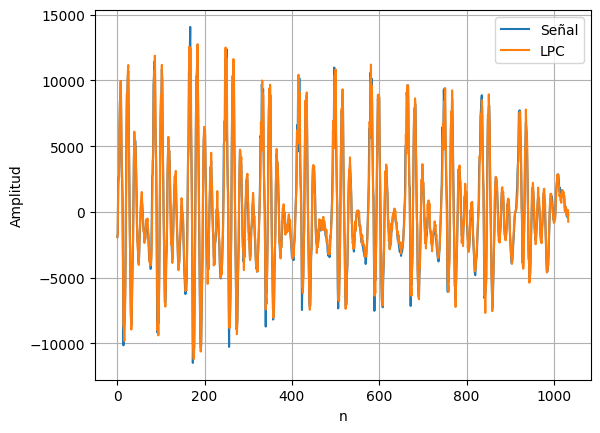

In [122]:

# Aquí vamos a calcular los coeficientes LPC de la señal.

p = 10 # Orden del LPC

n_datos = len(señal)
A = [[señal[p-(i+1)+j] for i in range(p)] for j in range(n_datos-p)]
b = señal[p:]

# np.linalg.lstsq resuelve A*a=b por cuadrados mínimos [19]
a = np.linalg.lstsq(A,b)[0]

# Construimos la aproximación de la señal mediante LPC con los coeficientes en a
s_lpc = list(señal[:p]) # Los primeros p puntos van a ser y[n]=x[n] (0<=n<p)
for i in range(n_datos - p):
  s_lpc.append(sum([a[k]*señal[i-(k+1)+p] for k in range(p)]))

# Graficamos la señal y la aproximación mediante LPC
plt.plot(t, señal, label = "Señal")
plt.plot(t,(s_lpc),label="LPC")
plt.legend()
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

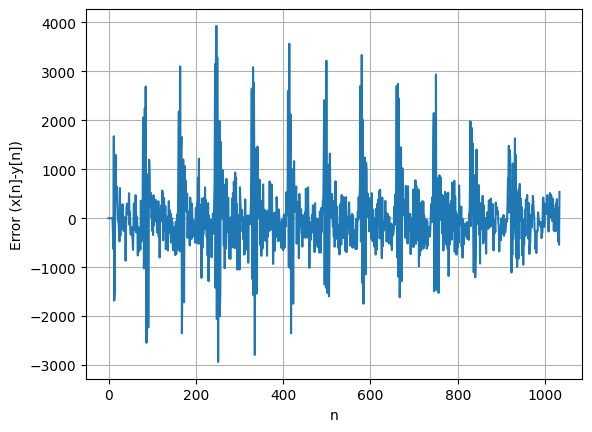

In [123]:
# Graficamos el error
e = np.array(señal)-np.array(s_lpc)
plt.plot(t,e)
plt.xlabel("n")
plt.ylabel("Error (x[n]-y[n])")
plt.grid()
plt.show()

In [124]:

# Calculamos la transformada Z del filtro LPC

# Primero creamos un array que contenga 1 y los coeficientes con el signo cambiado
a = np.append(np.array(1),-a)

# La función freqz de scipy.signal nos ayuda a calcular H(z) tal como se la definió en (7) [24]
w, h = freqz(1, a, int(fs/2)) # h = 1 / sum(a[k]*z^-k) ; w son las frecuencias

# h es la transformada Z del filtro evaluada sobre el círculo unidad
# de los complejos, lo que habíamos llamado H(z=e^(iw)) más arriba.
h = np.abs(h)

# Tomamos log al módulo de H(z) para tomar de referencia en dB
envolvente = 20*np.log10(np.abs(h))


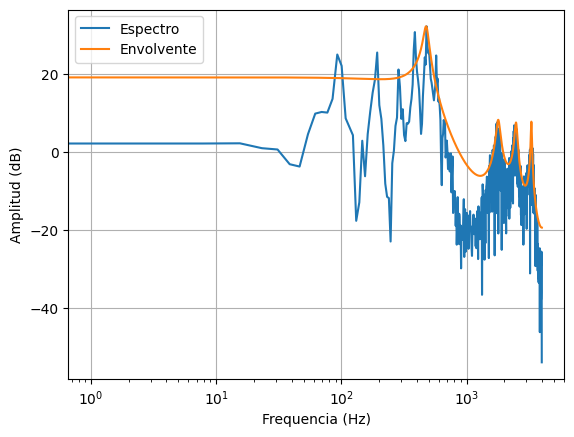

In [125]:

# Graficamos el espectro y su envolvente

f, data_fft = fft_archivo(n_datos, señal, n_datos, fs)

# Normalizamos la señal en dB con la envolvente como referencia
data_fft = 20*np.log10(data_fft)
data_fft = data_fft + np.array(max(envolvente) - np.max(data_fft))

plt.plot(f, data_fft,label = 'Espectro')

# Normalizamos w (omega) que iba entre 0 y pi para
# pasar al dominio de frecuencias (entre 0 y fs/2)
w = np.abs(w)*fs/2/np.pi

# (tenemos que usar w en vez de f ya que tiene más puntos)
plt.plot(w, envolvente, label='Envolvente')

plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

Formantes (Hz):  [474.99999999999994, 1792.0, 2485.0, 3296.0000000000005]


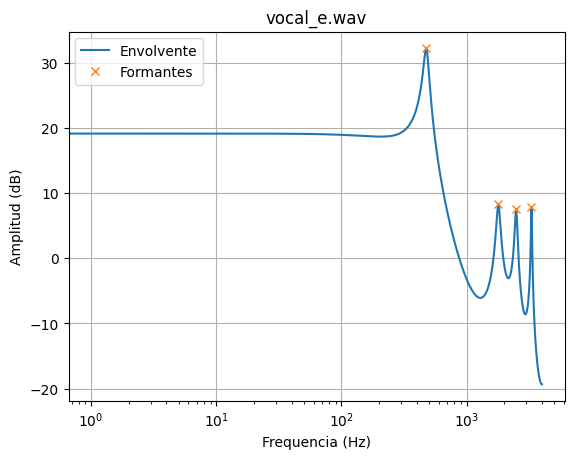

In [126]:
# Hallamos los picos de la envolvente para determinar las formantes (como hicimos para sacar los armónicos)

peaks,_ = sps.find_peaks(envolvente)
print("Formantes (Hz): ",[w[p] for p in peaks])

plt.plot(w, envolvente, label='Envolvente')
plt.plot([w[p] for p in peaks], [envolvente[p] for p in peaks], "x", label = "Formantes")

plt.title(archivo.split("/")[-1])
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Amplitud (dB)')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()



$\hspace{1cm}$ En la carpeta **/Archivos_señales/Audios** hay muestras de sonido de las $5$ vocales en castellano (de un mismo hablante) para ubicar las formantes, como se ve en las imágenes que siguen.

<img src="./Archivos_señales/a-spectrum.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
<img src="./Archivos_señales/e-spectrum.png"
     alt="Markdown Monster icon"
     style="float: center; margin-right: 10px;" />
<img src="./Archivos_señales/i-spectrum.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
<img src="./Archivos_señales/o-spectrum.png"
     alt="Markdown Monster icon"
     style="float: center; margin-right: 10px;" />
<img src="./Archivos_señales/u-spectrum.png"
     alt="Markdown Monster icon"
     style="float: right; margin-right: 10px;" />


# 5.B) Praat

$\hspace{1cm}$ Hasta aquí, tenemos las herramientas necesarias para analizar archivos de audio de una vocal aislada. No nos vamos a meter en este trabajo con cómo recortar los registros sonoros para separar en el habla las consonantes de las vocales.

$\hspace{1cm}$ Ahora bien, en los casos que analizamos previamente, las formantes eran fácilmente distinguibles. No suele ser el caso de la vocal "o", por ejemplo como podemos ver en el gráfico de la celda anterior, donde F2 está casi montada sobre F1; termina resultando para algunas vocales que hay que tomar un $p$ mayor y para otras uno menor que $12$, teniendo que hacerse cierto trabajo de sintonía fina caso por caso.

$\hspace{1cm}$ Podríamos intentar sistematizar este algoritmo, pero si quisiéramos tener una muestra suficientemente grande como para poder promediar los valores de las formantes, e incluso generar una región típica de cada vocal, esto sería demasiado engorroso.

$\hspace{1cm}$ Nos aprovechamos entonces de la existencia del programa _praat_, desarrollado en 2001 por Paul Boersma y David Weenink del Fepartamento de Ciencias Fonéticas de la Universidad de Amsterdam **[25-26]**, el cual permite analizar archivos de audio, seleccionar la región en la que se pronuncia la vocal (suele ser mejor tomar solamente una sección del medio del audio), y con unos clicks obtener las formantes. Las calcula también a partir del modelo de LPC, pero usa varios algoritmos más para optimizar (con los que no nos vamos a meter, pero se mencionan en la documentación **[27]**).

$\hspace{1cm}$ En **[28]** se analizaron varios programas de análisis de audio para obtener las formantes, y se recomienda el uso de _praat_. En **[29]** y **[30]** se tiene una explicación más detallada del uso del programa para esto.




# Sección 6: Dataset

$\hspace{1cm}$ En la carpeta adjunta **/Archivos_señales** vamos a encontrar un grupo de datos de F1 y F2 clasificados según la vocal del audio (que se obtuvieron siguiendo el análisis detallado en la sección anterior), a partir de los cuales intentaremos replicar el gráfico de **[13]**. Trabajaremos con las formantes tomadas de los audios de $18$ personas pronunciando las $5$ vocales del castellano.

$\hspace{1cm}$ Para aclarar, este grupo de datos se tomó con micrófonos distintos, con distintas condiciones de ruido de fondo y sin tomar promedios ni considerar demasiado el rango donde estimar las formantes. Aún con esta falta de rigurosidad, veremos que podemos constatar los modelos que veníamos mencionando.


# Sección 7: KNN

$\hspace{1cm}$ Para analizar y visualizar la clasificación de los datos que tenemos podemos usar un algoritmo que se llama K-primeros vecinos (KNN por sus siglas en inglés). Vamos a separar el $80$% de nuestros datos al azar para determinar esta clasificación, mapeando todo el espacio de fases según este criterio, y luego usaremos el $20$% restante para probar su precisión. Esto deberíamos repetirlo varias veces, calculando cada vez esta precisión como cantidad de datos bien clasificados / cantidad de datos de prueba, y promediarlo, pero vamos a ignorar este paso; sólo queremos darnos una idea de cómo quedaría la clasificación extendida, pero se podría usar este método para clasificar nuevos audios. El valor del precisión nos daría una idea de cuán bueno podemos esperar que sea este algoritmo para hallar la clasificación correcta.

$\hspace{1cm}$ De manera sencilla, se trata de ubicar un punto en F2 vs F1, reconocer los $k$ vecinos más cercanos en el espacio de parámetros dentro del dataset, y contar aquella clase que se repite más veces.


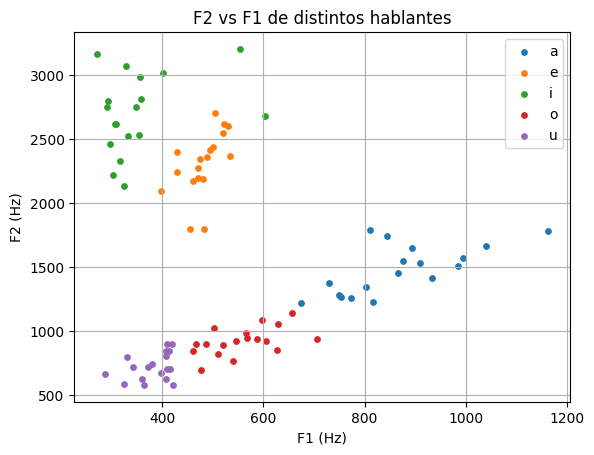

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Abrimos el archivo con los datos
df = pd.read_csv("./Archivos_señales/dataset_vocales.csv",sep=";")

# Graficamos los puntos del dataset en el espacio de parámetros a ver si efectivamente se ven zonas bien definidas

def classificar(df, param, vocal):
  return [df[param][i] for i in df[param].index if df["vocal"][i]==vocal]

param1 = "F1"
param2 = "F2"

# Asignamos un entero a cada vocal para no trabajar con strings
vocales = {"a":0, "e":1, "i":2, "o":3, "u":4}

for vocal in vocales:
    v_1 = classificar(df, param1, vocales[vocal])
    v_2 = classificar(df, param2, vocales[vocal])
    plt.scatter(v_1, v_2, label=vocal, s=15)

plt.title("F2 vs F1 de distintos hablantes")
plt.xlabel(param1 + " (Hz)")
plt.ylabel(param2 + " (Hz)")
plt.legend()
plt.grid()
plt.show()


$\hspace{1cm}$ Efectivamente, pudimos replicar el comportamiento de los datos de **[14]** o **[16]**. Para definir el algoritmo que busque vecinos, definidos tal que estén a menor distancia en el espacio de parámetros, primero tendremos que normalizar en ambos ejes, así no se le da más peso al que tenga un rango mayor.


In [128]:
# Debemos normalizar los ejes del espacio de parámetros antes de calcular la distancia.
def normalizar(X, parametro):
    param = X[parametro]
    return (param-min(param))/(max(param)-min(param))

X_norm = df.copy()
X_norm[param1] = normalizar(df,param1)
X_norm[param2] = normalizar(df,param2)



$\hspace{1cm}$ Ahora, separaremos los datos en un grupo de entrenamiento y otro de prueba. Se seleccionarán al azar un $80$% de los datos para entrenamiento, y el resto para prueba.


In [129]:

# Los separamos en 2 grupos: uno de entrenamiento y el otro de prueba
norm_entrenamiento = X_norm.sample(frac=0.8, random_state=123)
norm_prueba = X_norm.drop(norm_entrenamiento.index)

# X serán los parámetros relevantes, e y será la clasificación (columna vocal)
X_entrenamiento = norm_entrenamiento.drop("vocal",axis=1)
y_entrenamiento = norm_entrenamiento["vocal"]

X_prueba = norm_prueba.drop("vocal",axis=1)
y_prueba = norm_prueba["vocal"]


$\hspace{1cm}$ Podemos ver los promedios para cada vocal y graficar elipses sobre el espacio de parámetros que den cuenta de la concentración de los puntos en cada caso.

$\hspace{1cm}$ Las elipses estarán centradas en el promedio de F1 y F2, y sus semiejes serán iguales a la desviación estándar en el eje correspondiente.

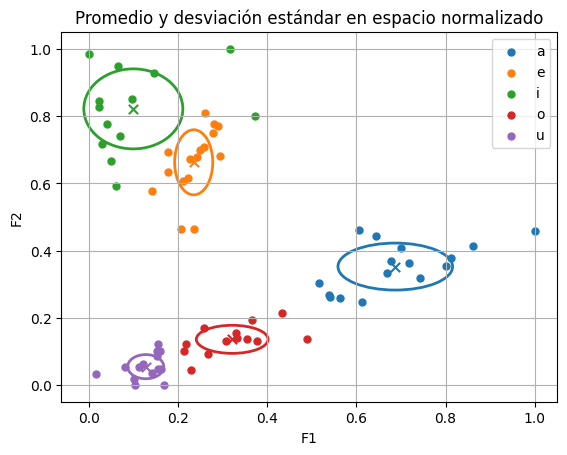

In [130]:
def promediar(v_f1, v_f2):

    prom1 = np.mean(v_f1)
    sd1 = np.std(v_f1)
    prom2 = np.mean(v_f2)
    sd2 = np.std(v_f2)

    return prom1, prom2, sd1, sd2

def plot_elipse(estadisticas, ax, color):

    prom1,prom2,sd1,sd2 = estadisticas
    elipse = Ellipse((prom1,prom2), width=2*sd1, height=2*sd2, edgecolor=color, fc='None', lw=2)
    ax.add_patch(elipse)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='auto')

promedios = {}

for vocal in vocales:
    v_1 = [X_entrenamiento[param1][i] for i in X_entrenamiento[param1].index if y_entrenamiento[i]==vocales[vocal]]
    v_2 = [X_entrenamiento[param2][i] for i in X_entrenamiento[param2].index if y_entrenamiento[i]==vocales[vocal]]

    estadisticas = promediar(v_1, v_2)
    promedios[vocal] = estadisticas # El diccionario "promedios" guarda el promedio de cada formante y su sd por vocal

    color = next(ax._get_lines.prop_cycler)['color']

    plt.scatter(v_1, v_2, label=vocal, color=color, s=25)
    plt.scatter(promedios[vocal][0], promedios[vocal][1], color=color, marker="x", s=45)
    plot_elipse(estadisticas, ax, color)

#plt.title("Espacio normalizado")
plt.title("Promedio y desviación estándar en espacio normalizado")
plt.xlabel(param1)
plt.ylabel(param2)
plt.legend()
plt.grid()
plt.show()


$\hspace{1cm}$ Ahora sí, buscaremos los $k$ vecinos, pero pondremos un umbral en las distancias, dada por la desviación estándar en cada eje, así evitamos la clasificación de datos que se encuentran por fuera de la región típica y que no corresponderían a vocales del castellano (evitaríamos también clasificar datos que ni siquiera se correspondan a una vocal). Este umbral es arbitrario, pero más adelante veremos su utilidad.


In [131]:

# Escribimos la función para hallar los primeros k vecinos a menor distancia en el espacio F2 vs F1

def knn(parametros, prueba, k):
    
    """
    Calculamos la distancia euclídea entre los datos de prueba y cada dato de entrenamiento
    dentro del espacio de parámetros seleccionados, y la guardamos en una nueva columna.
    """
    
    distancia = 0
    for param in parametros:
        distancia += (X_entrenamiento[param] - prueba[param])**2
    X_entrenamiento["distancia"] = (distancia)**0.5

    # Busca los k datos a menor distancia en el espacio de parámetros y busca la moda para clasificar el punto de prueba
    k_vecinos = X_entrenamiento["distancia"].nsmallest(n=k)
    prediccion = y_entrenamiento[k_vecinos.index].mode()[0]

    # Proponemos el umbral a partir de las desviaciones estándar de cada clase (vocal)
    sds = promedios[list(vocales.keys())[prediccion]]

    # Si el dato más cercano
    if np.any(np.where(k_vecinos < np.sqrt(sds[2]**2+sds[3]**2))):
        return prediccion
    else:
        return 5 # Esta nueva clase nos indicará que nos salimos de las vocales típicas del castellano

$\hspace{1cm}$ Finalmente calcularemos la precisión de este modelo, en este caso particular con la división azarosa de datos dada por la semilla "random_state", a partir de la cantidad de datos de prueba cuya clasificación fue acertada dividido la cantidad total de datos de prueba.

$\hspace{1cm}$ Por probar, elegiremos un número de $k$ razonable pero aun así arbitrario, digamos $5$ vecinos. La precisión variará también con este número.

In [132]:
parametros = ["F1", "F2"]
k = 5

# Generamos una nueva columna que guardará los valores de y predichos por el modelo de knn
X_prueba["y_predicho"] = [knn(parametros, X_prueba.iloc[i],k) for i in range(X_prueba.shape[0])]

# Comparamos las predicciones con la clasificación real de los datos de prueba
predicciones = [int(i==j) for i,j in zip(X_prueba["y_predicho"], y_prueba) ]

# Calculamos la precisión del modelo como la cantidad de clasificaciones
# bien asignadas sobre la cantidad total de datos de prueba
precision = predicciones.count(1)/len(predicciones)

print("Precisión (k=%.i):"%k, precision)

Precisión (k=5): 0.9444444444444444


$\hspace{1cm}$ Obtuvimos para la semilla y el $k$ que utilizamos una precisión del 94%, por lo que tenemos un buen clasificador. Se puede probar cómo cambia con otro random_state en la selección de datos de entrenamiento, y una precisión más representativa saldrá de promediar con varios valores. 

$\hspace{1cm}$ A continuación, podemos recuperar el dataset completo y ver cómo el knn clasifica _todo_ el espacio de parámetros. De esta manera, extrapolando el valor de precisión que obtuvimos con los datos de prueba, podemos intuir cómo se clasificarían nuevos datos a partir de la clasificación de los que ya tenemos.

In [133]:
# Aquí vamos a barrer todo el espacio de parámetros (normalizado) entre 0 y 1
# y colorearlo según la clasificación propuesta

from matplotlib.colors import ListedColormap

X_tot = pd.concat([X_entrenamiento, X_prueba])
y_tot = pd.concat([y_entrenamiento, y_prueba])
X = np.array([[j for j in i] for i in np.array(X_tot.iloc[:,:2])])
y = y_tot

colores_fondo = ['#FFAAAA', '#AAFFAA', '#AAAAFF','#AAFFFF','#FFAAFF','#FFFFFF']
colores_puntos = ['#FF0000', '#00FF00', '#0000FF','#00FFFF','#FF00FF']

# Creamos un mapa de color (asignará colores a cada clase cuando grafiquemos)
cmap_light = ListedColormap(colores_fondo)
cmap_bold = ListedColormap(colores_puntos)

# Generamos una cuadrícula en el plano xy entre -0.1 y 1.1 cada 0.02
h = 0.02  # Ancho de cada elemento en la cuadrícula
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

xy = {"F1": xx.ravel(), "F2": yy.ravel()}
plano = pd.DataFrame(xy)

# Estima la clasificación barriendo el espacio de parámetros
Z = [knn(parametros, plano.iloc[i], k) for i in range(plano.shape[0]) ]
"""
ravel() pasa array N-D a 1D (xx e yy eran matrices de NxN, pasa a medir 1xN^2).
Entonces le estamos pasando a knn los pares de puntos que barren todo el espacio para que los clasifique.
"""

# Pasamos Z a una matriz 2D para graficar
Z = np.array(Z).reshape(xx.shape)


In [134]:

# Antes de graficar, volvamos al rango de frecuencias original

min_df = {"F1": np.min(df["F1"]), "F2": np.min(df["F2"])}
max_df = {"F1": np.max(df["F1"]), "F2": np.max(df["F2"])}

def rango_completo(datos,param):
    return min_df[param] + datos*(max_df[param]-min_df[param])

xx_rango_completo = rango_completo(xx, "F1")
yy_rango_completo = rango_completo(yy, "F2")

X_rango_completo = X.copy()
X_rango_completo[:, 0] = rango_completo(X[:, 0], "F1")
X_rango_completo[:, 1] = rango_completo(X[:, 1], "F2")


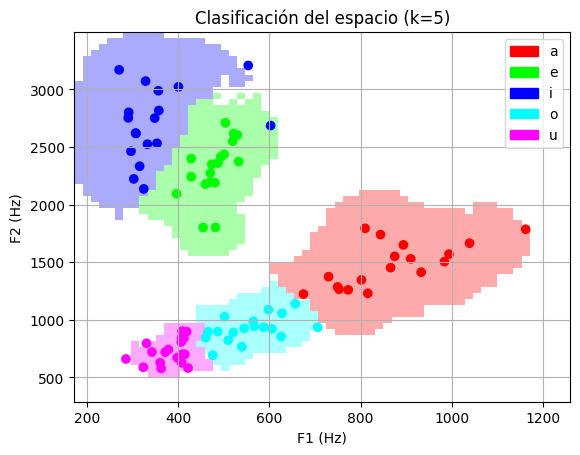

In [135]:
from matplotlib.patches import Patch

# Graficamos la clasificación con los colores seleccionados
plt.figure()
plt.pcolormesh(xx_rango_completo, yy_rango_completo, Z, cmap=cmap_light)

# Graficamos los datos también
plt.scatter(X_rango_completo[:, 0], X_rango_completo[:, 1], c=y, cmap=cmap_bold)
plt.xlabel('F1 (Hz)')
plt.ylabel('F2 (Hz)')
plt.title('Clasificación del espacio (k={})'.format(k))
plt.grid()

# Agregamos referencia a los datos
handles = []
for i in vocales:
  handles.append(Patch(color=colores_puntos[vocales[i]], label=i))
plt.legend(handles=handles)

plt.savefig("./Archivos_señales/Clasificacion_vocales.png")
plt.show()

$\hspace{1cm}$ Notemos que, si no se hubiera agregado un umbral al algoritmo de clasificación, se habría coloreado todo el espacio, como si toda combinación de frecuencias F1 y F2 se correspondiera con las formantes de una vocal del castellano, lo cual no es así. Por ejemplo, entre la F2 de la "e" y la "o", como se ve en **[16]**, existen en inglés $2$ vocales que no se corresponden a fonemas en nuestro idioma.

$\hspace{1cm}$ Puede que el umbral puesto a una desviación estándar de cada clase haya sido demasiado restrictivo, ya que algunos datos se terminan saliendo de la clasificación, pero probablemente esto se arregle tomando una muestra más grande.

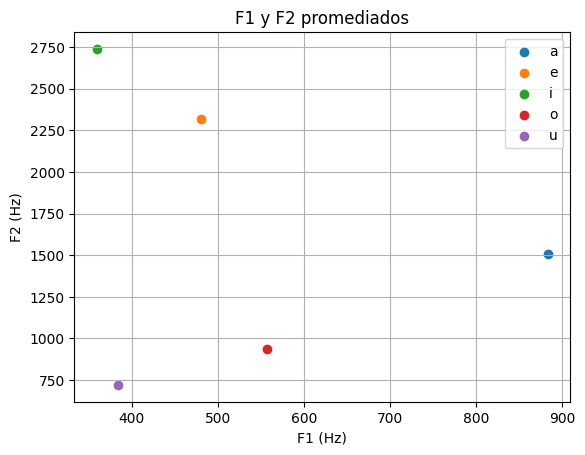

In [136]:
# Por último, graficaremos los promedios
for vocal in promedios:
  f1_prom = rango_completo(promedios[vocal][0], "F1")
  f2_prom = rango_completo(promedios[vocal][1], "F2")
  plt.scatter(f1_prom, f2_prom, label = vocal)

plt.xlabel('F1 (Hz)')
plt.ylabel('F2 (Hz)')
plt.title("F1 y F2 promediados")
plt.grid()
plt.legend()
plt.show()

# Sección 8: Conclusiones

$\hspace{1cm}$ Pudimos transformar y visualizar una señal de audio en el espacio de frecuencias usando la FFT para detectar la fundamental y los armónicos de una misma nota sonando en distintos instrumentos musicales. De manera similar, analizamos audios de personas pronunciando las $5$ vocales del castellano, y vimos cómo el espectro de frecuencias nos da información sobre la manera en la que modificamos nuestro tracto vocal para enunciarlas. A partir del modelo LPC hallamos la envolvente de los espectros para determinar las formantes típicas, y con el algoritmo de $K$ primeros vecinos, habiendo analizado $90$ audios con el programa _praat_, pudimos mapear en el espacio de parámetros F2 vs F1 a las vocales del castellano.


# Bibliografía


**[1]** Roberts, M. J. (2005). Capítulo 7: El muestreo y la transformada de Fourier discreta, en _Señales y sistemas_ (1ra ed., pp. 407-472). Mcgraw-Hill.

**[2]** _Understanfing the FFT Algorithm_, de Pythonic Preambulations. Consultado el 6/3/23 en https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

**[3]** Cooley, J. W., & Tukey, J. W. (1965). _An algorith for the machine calculation of complex Fourier series_. Math. Comp. 19, 297-301.

**[4]** _Butterfly diagram_, de Wikipedia. Consultado el 6/3/23 en https://en.wikipedia.org/wiki/Butterfly_diagram

**[5]** _NumPy numpy.fft.fft documentation_, de Numpy. Consultado el 6/3/23 en https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html

**[6]** _Musical Instruments_, de Dan Ellis. Consultado el 6/3/23 en https://www.ee.columbia.edu/~dpwe/sounds/instruments/

**[7]** _Frecuencias de afinación del piano_, de Wikipedia. Consultado el 6/3/23 en https://es.wikipedia.org/wiki/Frecuencias_de_afinaci%C3%B3n_del_piano

**[8]** _SciPy scipy.signal.find_peaks documentation_, de Scipy. Consultado el 6/3/23 en https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

**[9]** Tokuda, I. (2021).  _The Source–Filter Theory of Speech_. Oxford Research Encyclopedia of Linguistics. Consultado el 6/3/23 en https://oxfordre.com/linguistics/view/10.1093/acrefore/9780199384655.001.0001/acrefore-9780199384655-e-894.

**[10]** Stam, D. C. (1989). Chapter 3: Production, acoustic and the perception of vowels, en _Vowel recognition in continuous speech_. Tesis realizada en Rochester Institute of Technology.

**[11]** Ladefoged, P. (1996). Chapter 7: The production of speech, en _Elements of acoustic phonetics_ (2da ed., pp 92-113). The University of Chicago Press.

**[12]** _Harmonics vs formants_, de Voice Science Works. Cosultado el 6/3/23, enhttps://www.voicescienceworks.org/harmonics-vs-formants.html

**[13]** Bradlow, A. R. (1995). _A comparative acoustic study of English and Spanish vowels_. Journal of the Acoustical Society of America, 97(3), 1916–1924.

**[14]** Hirahara, T. & Akahan-Yamada, R. (2001). _Acoustic characteristics of Japanese vowels_. Proc. 18th ICA, 3387-3290.

**[15]** Ladefoged, P. (2001). Chapter 3: Vowel contrasts, en _Vowels and consonants: an introduction to the sounds of languages_ (1ra ed., pp 181-214). The University of Chicago Press.

**[16]** Peterson, G. E. & Barney, H. L. (1951). _Control methods used in a study of the vowels_. The Journal of the Acoustic Society of America. 24, 2, 175-185.

**[17]** Ladefoged, P. (1996). Chapter 11: Digital filters and LPC analysis, en _Elements of acoustic phonetics_ (2da ed., pp 181-214). The University of Chicago Press.

**[18]** _Regresión lineal: estimación de los parámetros_, de Wikipedia. Consultado el 6/3/23 en https://es.wikipedia.org/wiki/Regresi%C3%B3n_lineal#Estimaci%C3%B3n_de_los_par%C3%A1metros_2

**[19]** _NumPy numpy.linalg.lstsq documentation_, de NumPy. Consultado el 6/3/23 en https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html

**[20]** Roberts, M. J. (2005). Capítulo 11: La transformada Z, en _Señales y sistemas_ (1ra ed., pp. 407-472). Mcgraw-Hill.

**[21]** _Linear Predictive Coding is All-Pole Resonance Modeling_, de Center for Computer Research in Music and Acoustics. Consultado el 6/3/2023 en https://ccrma.stanford.edu/~hskim08/lpc/

**[22]** _Spectral envelope extraction_, de DSP related. Consultado el 6/3/23 en https://www.dsprelated.com/freebooks/sasp/Spectral_Envelope_Extraction.html

**[23]** _Linear predictive coding in Python_, de Guilherme Kunigami. Consultado el 6/3/23 en https://www.kuniga.me/blog/2021/05/13/lpc-in-python.html

**[24]** _SciPy scipy.signal.freqz documentation_, de Scipy. Consultado el 6/3/23 en https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html

**[25]** _Praat: doing phonetics by computer_, del Departamento de Ciencias Fonéticas de la Facultad de Humanidades de la Universidad de Amsterdam. Consultado el 6/3/23 en https://www.fon.hum.uva.nl/praat/

**[26]** Boersma, P. & van Heuven, V. (2001). _Speak and unSpeak with Praat_. Glot International. 5. 341-347.

**[27]** _LPC_, de Praat Manual. Consultado el 6/3/23 en https://www.fon.hum.uva.nl/praat/manual/LPC.html

**[28]** Schiel, F., & Zitzelsberger, T. (2018). _Evaluation of Automatic Formant Trackers_. Proceedings of the International Conference on Language Resources and Evaluation. 2843-2848.

**[29]** _Speech Acoustics 5 – vowel formants_, de la lista Intro to Speech Acoustics de Listen Lab (en YouTube). Consultado el 6/3/2023 en https://www.youtube.com/watch?v=glnUFa2fLyE&list=PL6niCBwOhjHhQFfl88fQfdLgiD7QaShBo

**[30]** _Praat for Beginners: Making spectral slices (LPC)_, de SWPhontics. Consultado el 6/3/2023 en https://swphonetics.com/praat/objects-window/lpc-slices/
